# Code for Fig. 1

In [1]:
%load_ext autoreload
%autoreload 1
%aimport general_functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from general_functions import g0_fun, compute_energies, dos_general, plot_band_structure, check_convergence

## Band structure and DoS (b-c)

The system consists in a 2D square array with lattice constant $d$. Each dipole have is a two level system with a optical transition frequency $\omega_0=k_0c=2\pi c/\lambda_0$, a free space decay rate given by $\Gamma_0$, and a polarization $\wp_0$. Additionaly, impurity atoms can be located near the metaruface with individual optical transition frequency, fre space decay rate and polarization.

The non-Hermitian Hamiltonian that describes the system is given by:

\begin{equation}
    \frac{H_{m}}{\hbar} = \sum_{j=1}^N\left(\omega_0-i\frac{\Gamma_0}{2}\right) \sigma^j_{ee}+\sum_{i\neq j=1}^N\left(J_{ij}-i\frac{\Gamma_{ij}}{2}\right)\sigma_{eg}^i\sigma_{ge}^j\,,
\end{equation}

where the coherent and incoherent emitter interactions is given by the vacuum Green's function

\begin{equation}
    J_{ij}-i\frac{\Gamma_{ij}}{2}=-\frac{3\pi \Gamma_0}{\omega_0}\hat{\boldsymbol{\wp}}^*_{i} \cdot\mathbf{G}_0(\mathbf{r}_i-\mathbf{r}_j)\cdot\hat{\boldsymbol{\wp}}_{j}.
\end{equation}

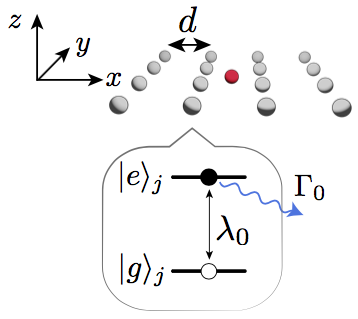

In [5]:
polarizations = [np.array([[0, 1, 0]]).T]  # Polarization of lattice

d = 1  # Lattice constant
lambda0 = d / 0.3  # Wave-lenght of transition
k0 = 2 * np.pi / lambda0

aho = 0.1 * d  # Cut-off in momentums

nmax = 9  # Number of reciprocal lattice in the summatory

# Reciprocal lattice vectors
b1 = 2 * np.pi / d * np.array([1, 0])
b2 = 2 * np.pi / d * np.array([0, 1])

A = d ** 2  # Area of unit cell in real space

# Symmatric points
Gamma = [0, 0]  # 0
M = [np.pi / d, np.pi / d]  # 1
X = [np.pi / d, 0]  # 2
Y = [0, np.pi / d]  # 3
order = [1, 0, 2, 1]  # Order of the symmetric points

points = [Gamma, M, X, Y]
names = [r'$\Gamma$', r'$M$', r'$X$', r'$Y$']

points_label = []
points_site = []

# Sort the symmetric points in the desired order
for i in order:
    points_label.append(names[i])
    points_site.append(points[i])
    
G0 = g0_fun(k0, aho)  # Renormalizated Green function in k = 0

In [5]:
# Check that the summatory in the reciprocal lattice has converged, if not, automatically increase the number of vectors
nmax, J_band, Gamma_band = check_convergence(points_site, b1, b2, A, nmax, k0, aho, G0=G0, n=100, limit_error=1e-5,
                                             print_progress=True, polarizations=polarizations, bands=None, step=2)

Step: 1, Avg error: 9.218701356357902e-08
Number of reciprocal sites for lattice sum: 9


In [6]:
n = 401  # Number of momentum to evalueate in each direction (total sites is N = n²)
k_x = (np.arange(-n // 2, n // 2) + 1) / (n // 2) * np.pi / d
k_x, k_y = [x.flatten() for x in np.meshgrid(k_x, k_x)]

k = np.vstack((k_x, k_y)).transpose()  # Momentum at which compute the bands
J, Gamma = compute_energies(b1, b2, A, nmax, k0, aho, k, G0=G0, polarizations=polarizations)  # Compute the energy in the given momentums

n_bands = np.shape(J)[1]  # Number of bands

In [7]:
# Limits for the energy
limit_sup = 1.5
limit_inf = -1

DoS = []
for i in range(n_bands):
    # Compute the DoS for each band
    energy, DoS_temp = dos_general(J[:, i], min_E=limit_inf, max_E=limit_sup, args=[0.01])
    DoS.append(DoS_temp)
    
DoS_total = sum(DoS)  # Total DoS, taking into account all the bands

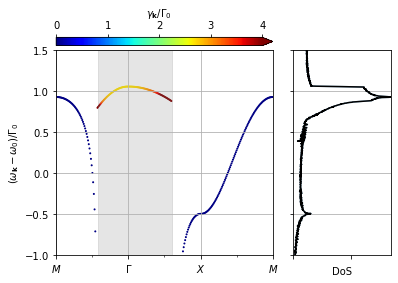

In [8]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))

light = [-k0 / np.sqrt(2) / np.pi, k0 / np.pi]

plot_band_structure(fig, ax1, J_band, Gamma_band, points_label, limit_inf=limit_inf, limit_sup=limit_sup,
                    label_cbar=r'$\gamma_\mathbf{k}/\Gamma_0$', cbar_norm=4, limit_light=light, dos=DoS,
                    energy_dos=energy, ax_dos=ax2)

## Color maps (d-f)

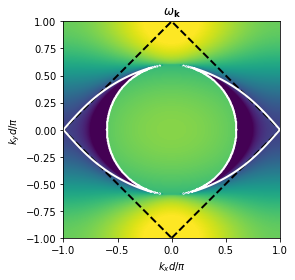

In [42]:
fig, ax = plt.subplots()

J_plot = J[:, i].reshape((n, n))
im = ax.imshow(J_plot, extent=(-1, 1, -1, 1), vmin=limit_inf, vmax=limit_sup, origin='lower')
contours = ax.contour(k_x.reshape((n, n)) / np.pi, k_y.reshape((n, n))  / np.pi, J_plot,
                                 [J_plot[n // 2, -1]], colors='w', linewidths=2, linestyles='-')

ax.set_xlabel(r'$k_x d / \pi$')
ax.set_ylabel(r'$k_y d / \pi$')
    
ax.set_title(r'$\omega_\mathbf{k}$')

rectangle = plt.Rectangle((0, -1), np.sqrt(2), np.sqrt(2), edgecolor='k',
                          fill=False, angle=45, ls='--', lw=2)
ax.add_patch(rectangle)

fig.tight_layout()